
# Getting Started — `fluxfootprints.new_ffp.FFPclim`

This notebook demonstrates how to compute a simple flux‐footprint climatology using the **`FFPclim`** class from `new_ffp.py` in the `fluxfootprints` library.

You'll learn how to:
1. Load the included sample data (`US-UTE` half-hourly file) and site INI.
2. Prepare columns expected by `FFPclim`.
3. Run the model and view the footprint climatology.
4. Derive and plot an 80% source-area contour.
5. (Optional) Export results to a NetCDF file.

> Tip: The code is written to work in your repo layout (using `sys.path.append("../../src")`) **or** directly with a local copy of `new_ffp.py` if you drop this notebook next to it.


In [1]:

# --- Imports & path setup ----------------------------------------------------
import sys, os
from pathlib import Path
import configparser
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt


sys.path.append("../../src")
from fluxfootprints.new_ffp import FFPclim



In [2]:

def first_existing(paths):
    for p in paths:
        if p.exists():
            return p
    return None

ini_path = Path("./input_data/US-UTE.ini")
csv_path = Path("./input_data/US-UTE_HH_202406241430_202409251400.csv")

print("INI path:", ini_path)
print("CSV path:", csv_path)


INI path: input_data\US-UTE.ini
CSV path: input_data\US-UTE_HH_202406241430_202409251400.csv


In [5]:

# --- Read site INI and time series CSV ---------------------------------------
cfg = configparser.ConfigParser(interpolation=None)
# Ensure case-sensitive keys in the [DATA] section (we map explicitly below anyway)
cfg.optionxform = str
cfg.read(ini_path)

date_fmt = cfg.get("METADATA", "date_parser", fallback="%Y%m%d%H%M")
date_col = cfg.get("DATA", "datestring_col", fallback="TIMESTAMP_START")

# Load a subset of columns we need for FFPclim
# These names come from the US-UTE sample and FFPclim expectations
usecols = [
    date_col,
    "MO_LENGTH",    # will be renamed to 'ol'
    "USTAR",        # -> 'ustar'
    "V_SIGMA",      # -> 'sigmav'
    "WD",           # we convert to 'wd' (lower) so FFPclim can map -> 'wind_dir'
    "WS",           # we convert to 'ws' (lower) so FFPclim can map -> 'umean'
]

df = pd.read_csv(
    csv_path,
    usecols=lambda c: c in usecols,  # robust to extra columns
    parse_dates=[date_col],
)

# Make the timestamp a proper index
df = df.rename(columns={date_col: "time"}).set_index("time").sort_index()

# The library's new_ffp.py currently renames lowercase 'wd' -> 'wind_dir' and 'ws' -> 'umean'
# so we mirror that here to keep the workflow consistent.
if "WD" in df.columns and "wd" not in df.columns:
    df = df.rename(columns={"WD": "wd"})
if "WS" in df.columns and "ws" not in df.columns:
    df = df.rename(columns={"WS": "ws"})

print("Columns after basic normalization:", list(df.columns))
print(df.head())


Columns after basic normalization: ['wd', 'ws', 'USTAR', 'MO_LENGTH', 'V_SIGMA']
                            wd        ws     USTAR  MO_LENGTH   V_SIGMA
time                                                                   
2024-06-24 14:30:00   83.82242  4.118659  0.285427  -21.72663  1.243537
2024-06-24 15:00:00   84.50763  3.128728  0.228795  -16.70326  1.085609
2024-06-24 15:30:00   98.68390  2.669845  0.278461  -38.81393  0.901596
2024-06-24 16:00:00   99.19427  2.552504  0.307955  -48.47143  0.830604
2024-06-24 16:30:00  115.64840  1.786293  0.301376  275.48160  0.658542


In [6]:

# --- (Optional) Pick a short demo period for speed ---------------------------
# Using a small time window keeps the demo snappy while you’re exploring.
# Set these to None to use the full period.
demo_start = df.index.min()
demo_end   = demo_start + pd.Timedelta(days=2)  # ~2 days of half-hourly data

df_demo = df.loc[demo_start:demo_end].copy()
print(f"Using rows from {df_demo.index.min()} to {df_demo.index.max()} (n={len(df_demo)})")


Using rows from 2024-06-24 14:30:00 to 2024-06-26 14:30:00 (n=97)


In [13]:

# --- Instantiate FFPclim -----------------------------------------------------
# You can tweak the domain size and grid resolution as needed.
# Smaller grids = faster; larger = more detail.

ffp = FFPclim(
    df=df_demo,
    domain=[-300.0, 300.0, -300.0, 300.0],   # meters [xmin, xmax, ymin, ymax]
    dx=5, dy=5,                                   # grid spacing (m)
    nx=400, ny=400,                               # number of cells in x and y
    rs=[0.5, 0.8],                                # we’ll use 50% and 80% contours later
    inst_height=2.5,                              # instrument height (m) if not in df
    atm_bound_height=2000.0,                      # boundary layer height (m) if not in df
    crop_height=0.2,                              # canopy/veg height (m)
    smooth_data=True,                             # Gaussian smooth the footprint
    verbosity=1,                                  # 0-5 (lower = quieter)
)
ffp


In [14]:

# --- Run the footprint calculation ------------------------------------------
out = ffp.run()
list(out.keys())


C:\Users\paulinkenbrandt\.conda\envs\py313\Lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


['x_2d', 'y_2d', 'fclim_2d', 'f_2d', 'rs']

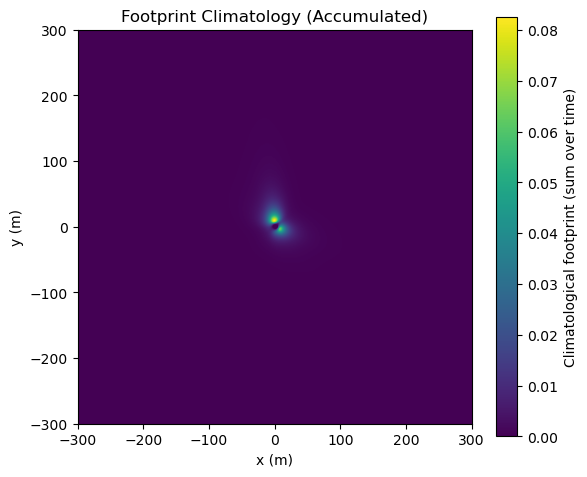

In [15]:

# --- Visualize the accumulated footprint climatology -------------------------
fclim = out["fclim_2d"]  # xarray.DataArray with dims ('x','y')

plt.figure(figsize=(6,5))
plt.imshow(fclim.T, origin="lower",
           extent=[ffp.x.min(), ffp.x.max(), ffp.y.min(), ffp.y.max()])
plt.colorbar(label="Climatological footprint (sum over time)")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Footprint Climatology (Accumulated)")
plt.tight_layout()
plt.show()


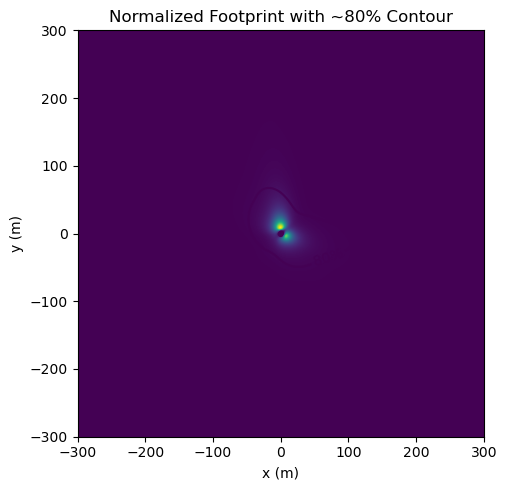

In [16]:

# --- Compute and plot an 80% source-area contour -----------------------------
# Normalize the climatology to sum to 1.0
f_norm = fclim / np.nansum(fclim.values)

# Convert to numpy arrays for thresholding
F = np.nan_to_num(f_norm.values, nan=0.0, posinf=0.0, neginf=0.0)

# Find the threshold value such that the sum of all cells >= threshold is ~0.80 of total
flat = F.ravel()
sort_idx = np.argsort(flat)[::-1]  # descending
cumsum = np.cumsum(flat[sort_idx])
target = 0.80
k = np.searchsorted(cumsum, target)
thresh = flat[sort_idx[k]] if k < len(flat) else flat[sort_idx[-1]]

# Plot
X, Y = np.meshgrid(ffp.x, ffp.y, indexing="xy")
plt.figure(figsize=(6,5))
plt.imshow(F.T, origin="lower",
           extent=[ffp.x.min(), ffp.x.max(), ffp.y.min(), ffp.y.max()])
cs = plt.contour(X, Y, F, levels=[thresh])
plt.clabel(cs, inline=True, fmt={thresh: "80%"})
#plt.colorbar(label="Normalized footprint")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Normalized Footprint with ~80% Contour")
plt.tight_layout()
plt.show()


In [17]:

# --- (Optional) Export to NetCDF --------------------------------------------
# Save the accumulated climatology and the per-timestep field.
export_nc = False  # set True to write a file

if export_nc:
    ds = xr.Dataset({
        "fclim_2d": fclim,     # accumulated climatology
        "f_2d": ffp.f_2d       # per-timestep field [time, x, y]
    })
    out_nc = Path("ffp_demo_output.nc")
    ds.to_netcdf(out_nc)
    print("Wrote", out_nc.resolve())
else:
    print("Set export_nc=True above to write a NetCDF file.")


Set export_nc=True above to write a NetCDF file.



## Next steps

- Increase `nx`, `ny` or shrink `dx`, `dy` for a higher-resolution grid (at the cost of compute time).
- Use your entire dataset by setting the demo window to `None` or expanding it.
- Try additional contours (e.g., `rs=[0.5, 0.8, 0.9, 0.95]`) and export polygons if needed.
- Integrate with your GIS workflow by converting the contour(s) to shapely and saving a GeoPackage.
- Explore weighting the climatology by flux magnitude before normalizing, if that suits your analysis goals.
